<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Inh"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level2-MajorCellType/Inh/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


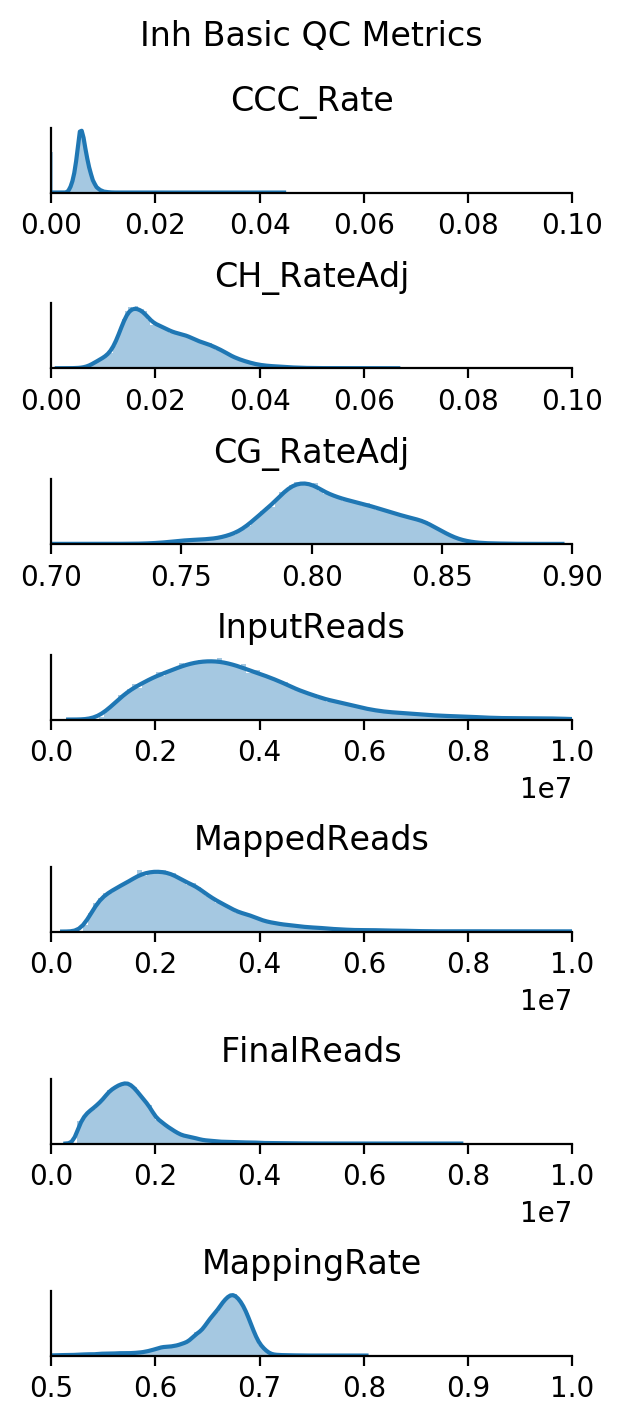

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

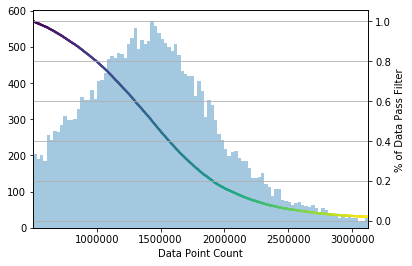

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 26893/26893 (100.0%)
CG_RateAdj passed 26893/26893 (100.0%)
CH_RateAdj passed 26893/26893 (100.0%)
FinalReads passed 26893/26893 (100.0%)
MappingRate passed 26893/26893 (100.0%)
Overall passed 26893/26893 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 127
171207 209
171212 27
171213 213
171214 931
171219 1221
180104 214
180109 683
180110 1085
180111 461
180119 230
180122 147
180123 141
180129 114
180130 182
180205 128
180206 124
180208 107
180212 94
180213 184
180220 315
180222 374
180226 206
180227 175
180305 155
180306 242
180312 164
180313 90
180319 40
180320 286
180326 188
180329 420
180402 361
180403 305
180405 766
180409 220
180410 227
180412 137
180416 141
180417 111
180419 123
180423 146
180424 93
180426 171
180430 164
180501 166
180514 98
180529 146
180605 131
180612 172
180724 173
180806 652
180911 1107
180917 757
180925 1204
181002 169
181008 175
181009 163
181015 1215
181016 1134
181022 123
181023 118
181204 729
181206 966
181210 200
181218 617
181220 1153
190108 92
190117 83
190122 200
190124 193
190131 148
190205 284
190207 1103
190212 121
190214 200
190219 104
190305 188
190307 129
190625 57
190627 91
190711 143
190716 147


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 3124 813.5%
ad002 3408 887.5%
ad004 3428 892.7%
ad006 3445 897.1%
ad007 3358 874.5%
ad008 3420 890.6%
ad010 3371 877.9%
ad012 3339 869.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,MappingRate,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_0,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008198,0.822633,0.821166,0.041640,0.033718,1626504.0,4407752,2892347.0,10E,...,0.656195,A1,CEMBA190625-10E-1,0,0,0,0,190625,10,True
10E_M_109,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005839,0.772664,0.771329,0.019089,0.013327,796516.0,1890630,1203975.0,10E,...,0.636812,B11,CEMBA190625-10E-1,10,1,20,3,190625,10,True
10E_M_1338,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.007324,0.814799,0.813433,0.036182,0.029071,1703622.0,4685660,3101242.0,10E,...,0.661858,G11,CEMBA190625-10E-4,10,6,20,13,190625,10,True
10E_M_150,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005896,0.758085,0.756650,0.023756,0.017967,1579104.0,4109724,2710612.0,10E,...,0.659561,B5,CEMBA190625-10E-1,4,1,9,2,190625,10,True
10E_M_1518,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007294,0.818669,0.817337,0.036374,0.029293,1972895.0,5551200,3483428.0,10E,...,0.627509,A10,CEMBA190627-10E-1,9,0,19,1,190627,10,True
10E_M_1526,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004817,0.764397,0.763256,0.016351,0.011589,1078279.0,2741252,1794215.0,10E,...,0.654524,A11,CEMBA190627-10E-1,10,0,21,1,190627,10,True
10E_M_1528,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008194,0.829654,0.828246,0.040873,0.032949,1822062.0,5265826,3262298.0,10E,...,0.619523,A11,CEMBA190627-10E-2,10,0,20,1,190627,10,True
10E_M_1540,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006985,0.815133,0.813832,0.038630,0.031868,2057810.0,6132020,3987159.0,10E,...,0.650220,A2,CEMBA190627-10E-1,1,0,2,1,190627,10,True
10E_M_1560,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.009671,0.826325,0.824629,0.049657,0.040376,2043560.0,5771766,3800581.0,10E,...,0.658478,A4,CEMBA190627-10E-2,3,0,7,0,190627,10,True
